In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

np.random.seed(42)

In [2]:
from tabulate import tabulate

def show_scores(clf, X, y):
    y_pred = clf.predict(X)
    y_pred_prob = clf.predict_proba(X)
    print(tabulate(confusion_matrix(y, y_pred), headers=['Predicted 0', 'Predicted 1'], tablefmt='orgtbl'))
    print()
    print(f'accuracy:              {round(accuracy_score(y, y_pred), 4)}')
    print(f'precision:             {round(precision_score(y, y_pred), 4)}')
    print(f'recall:                {round(recall_score(y, y_pred), 4)}')
    print(f'f1:                    {round(f1_score(y, y_pred), 4)}')
    print(f'roc_auc:               {round(roc_auc_score(y, y_pred), 4)}')
    print(f'roc_auc_pred_prob:     {round(roc_auc_score(y, y_pred_prob[:, 1]), 4)}')

In [3]:
X_train = pd.read_csv("../preprocessed_data/X_train.csv")
y_train = pd.read_csv("../preprocessed_data/y_train.csv")

X_val  = pd.read_csv("../preprocessed_data/X_val.csv")
y_val  = pd.read_csv("../preprocessed_data/y_val.csv")

In [4]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', C=14.38)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=100,max_depth=16)
xgb_clf = xgb.XGBClassifier(random_state=42, subsample=1, n_estimators=100, max_depth=3, learning_rate=0.3, gamma=5, colsample_bytree=0.8)
dct = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_split=4, min_samples_leaf=11,max_features=105)

In [5]:
parameters = dict(weights=[[i, j, k, l] for i in range(5) for j in range(5) for k in range (5, 10) for l in range (5, 10)])

estimators=[('DCT', dct), ('LR', log_reg), ('RandomForest', rfc), ('XGB', xgb_clf)]
rand_search = RandomizedSearchCV(VotingClassifier(estimators=estimators, voting='soft'), scoring='accuracy', cv=3, return_train_score=True, param_distributions=parameters, n_iter=100, n_jobs=1, random_state=42).fit(X_train, y_train)

In [6]:
rand_search.best_params_

{'weights': [0, 0, 7, 5]}

In [7]:
res = pd.DataFrame(rand_search.cv_results_).sort_values("mean_test_score", ascending=False)
for mean_score, params in zip(res["mean_test_score"], res["params"]):
    print(round(mean_score, 4), "   ", params)

0.899     {'weights': [0, 0, 7, 5]}
0.8989     {'weights': [3, 0, 9, 5]}
0.8989     {'weights': [1, 0, 9, 5]}
0.8989     {'weights': [1, 0, 7, 5]}
0.8989     {'weights': [0, 0, 9, 9]}
0.8989     {'weights': [4, 0, 8, 5]}
0.8989     {'weights': [2, 0, 9, 6]}
0.8989     {'weights': [2, 0, 8, 5]}
0.8989     {'weights': [1, 0, 6, 7]}
0.8989     {'weights': [1, 0, 6, 6]}
0.8988     {'weights': [1, 0, 9, 8]}
0.8988     {'weights': [4, 0, 7, 7]}
0.8988     {'weights': [2, 0, 9, 7]}
0.8988     {'weights': [2, 0, 9, 9]}
0.8988     {'weights': [0, 1, 7, 9]}
0.8988     {'weights': [0, 0, 5, 7]}
0.8988     {'weights': [1, 1, 9, 9]}
0.8988     {'weights': [0, 1, 9, 9]}
0.8988     {'weights': [0, 2, 9, 5]}
0.8988     {'weights': [0, 1, 6, 5]}
0.8988     {'weights': [2, 0, 7, 5]}
0.8987     {'weights': [4, 2, 9, 5]}
0.8987     {'weights': [4, 1, 7, 5]}
0.8987     {'weights': [3, 1, 6, 5]}
0.8987     {'weights': [3, 0, 9, 8]}
0.8987     {'weights': [2, 0, 7, 6]}
0.8987     {'weights': [0, 2, 7, 5]}
0.

In [8]:
show_scores(rand_search.best_estimator_, X_train, y_train)
show_scores(rand_search.best_estimator_, X_val, y_val)

|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         44668 |           127 |
|          4707 |          1586 |

accuracy:              0.9054
precision:             0.9259
recall:                0.252
f1:                    0.3962
roc_auc:               0.6246
roc_auc_pred_prob:     0.9341
|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         19092 |           120 |
|          2049 |           634 |

accuracy:              0.9009
precision:             0.8408
recall:                0.2363
f1:                    0.3689
roc_auc:               0.615
roc_auc_pred_prob:     0.7628


### Wizualizacje

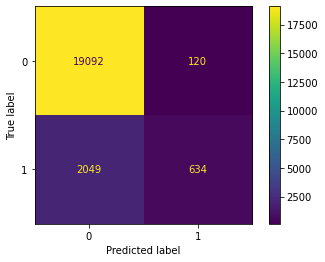

In [10]:
cm = confusion_matrix(y_val, rand_search.best_estimator_.predict(X_val), labels=rand_search.best_estimator_.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=rand_search.best_estimator_.classes_).plot()

In [11]:
def gini_roc(y_test, y_pred_proba, tytul):

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

def gini_train_val(model, X_train, y_train, X_val, y_val):

    y_pred_proba = model.predict_proba(X_train)[::,1]
    gini_train = gini_roc(y_train, y_pred_proba, "ROC Curve for Training Sample")
    print("gini_train: %.4f" % gini_train)

    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print("gini_val: %.4f" % gini_val)

    return

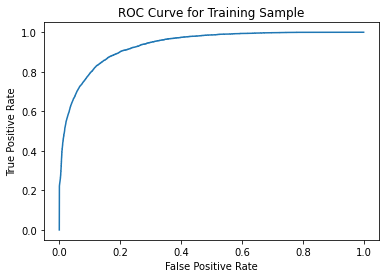

gini_train: 0.8682


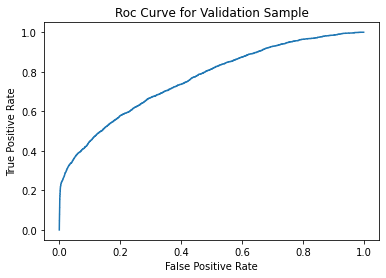

gini_val: 0.5256


In [12]:
gini_train_val(rand_search.best_estimator_, X_train, y_train, X_val, y_val)